In [29]:
#| echo: false
import warnings
warnings.filterwarnings('ignore')

import pandas as pd  
import numpy as np  
from scipy.stats import pearsonr, pointbiserialr, chi2_contingency  
import matplotlib.pyplot as plt  
from matplotlib.font_manager import FontProperties  

# Read the data  
file_path = 'data/listings.csv'    #which is the path in this repository  
airbnb_data = pd.read_csv(file_path)  

In [30]:
# Calculate the estimation of nights booked for each listing
airbnb_data = airbnb_data[airbnb_data['availability_365'] > 0] 
airbnb_data['estimated_nights_booked'] = airbnb_data['reviews_per_month'] * 12 * airbnb_data['minimum_nights'] * 2 

In [31]:
#Data cleaning: assign the estimated nights booked to each borough
# Replace NaN with 0
airbnb_data['estimated_nights_booked'] = airbnb_data['estimated_nights_booked'].fillna(0)

# Convert the column to integers
airbnb_data['estimated_nights_booked'] = airbnb_data['estimated_nights_booked'].astype(int)

#Count the number of listings in each borough using 'neighbourhood' column
borough_counts = airbnb_data['neighbourhood'].value_counts()

# Filter the DataFrame to include only rows where estimated_nights_booked is greater than 90
filtered_data = airbnb_data[airbnb_data['estimated_nights_booked'] > 90]

#Count the number of listings with estimation of nights booked larger than 90 days in each borough
borough_counts_90 = filtered_data['neighbourhood'].value_counts()

In [32]:
# Merge the two series into a DataFrame
combined_data = pd.concat([borough_counts, borough_counts_90], axis=1, keys=['Total_listings', 'More_than_90'])

# Calculate the ratio of listings with more than 90 booked nights per total listings
combined_data['Ratio_of_more_than_90'] = combined_data['More_than_90'] / combined_data['Total_listings']

# Fill any NaN values that might occur if there are boroughs with no listings > 90 nights
combined_data['Ratio_of_more_than_90'] = combined_data['Ratio_of_more_than_90'].fillna(0)

# Data formatting and round to four decimal places
combined_data['Ratio_of_more_than_90'] = combined_data['Ratio_of_more_than_90'].apply(lambda x: round(x, 4))

# Rename the index label to 'Borough_name'
combined_data.index.rename('Borough_name', inplace=True)

In [33]:
# Load the borough codes
borough_code_file_path = 'data/borough_name_code.csv'
borough_codes = pd.read_csv(borough_code_file_path)

# Reset index in combined_data to turn the index into a regular column
combined_data.reset_index(inplace=True)
borough_codes.reset_index(inplace=True)

#Combine the ratio data and borough name with borough code by borough name
combined_data = pd.merge(combined_data, borough_codes[['Borough_name', 'Borough_code']], on='Borough_name', how='left')

# Set 'Borough_name' back as the index
combined_data.set_index('Borough_name', inplace=True)

# Save the updated DataFrame
combined_data.to_csv('data/borough_listings_ratio.csv', index=True)

In [34]:
import geopandas as gpd
import libpysal
from esda.moran import Moran, Moran_Local
import matplotlib.pyplot as plt
from libpysal.weights import Queen, KNN
import seaborn as sns

# Load data
ratio = pd.read_csv("data/borough_listings_ratio.csv")
borough = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

# merge
borough_ratio = borough.merge(ratio, left_on="GSS_CODE", right_on="Borough_code")

In [35]:
# Calculate neighbors using Queen contiguity
weights = Queen.from_dataframe(borough_ratio)
weights.transform = 'r'  # Row-standardize the weights

Global Moran's I: 0.458
P-value: 0.001


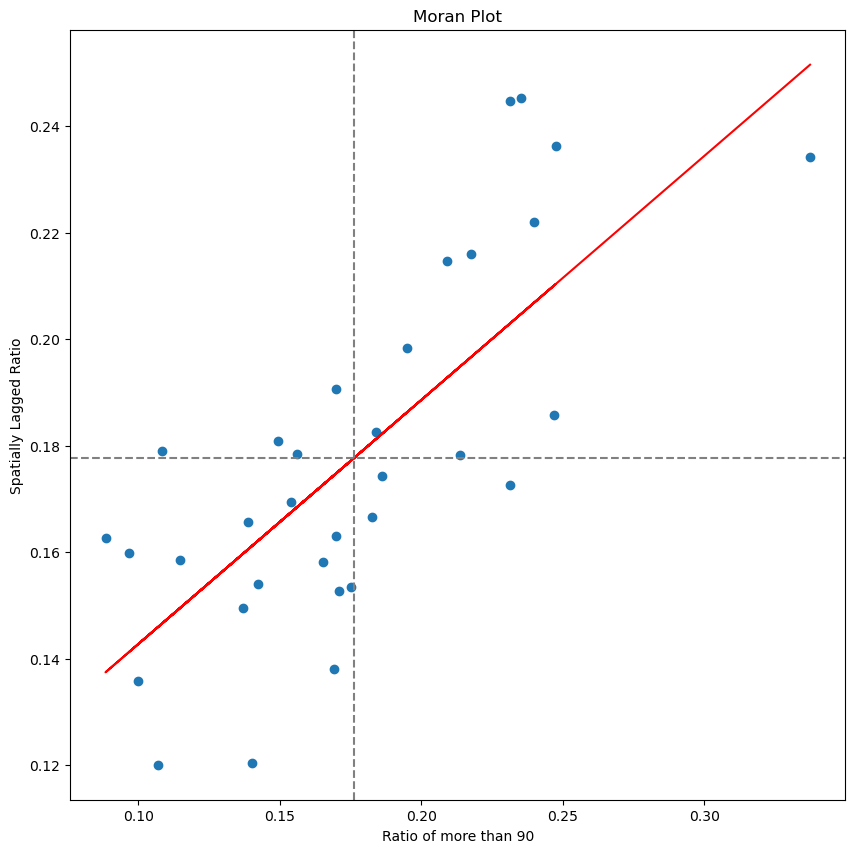

In [36]:
# Global Moran's I
y = borough_ratio['Ratio_of_more_than_90']
moran = Moran(y, weights)
print(f"Global Moran's I: {moran.I:.3f}")
print(f"P-value: {moran.p_sim:.3f}")

# Moran Plot
def moran_plot(y, weights):
    lag = weights.sparse.dot(y)
    slope, intercept = np.polyfit(y, lag, 1)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(y, lag)
    plt.plot(y, slope * y + intercept, 'r')
    plt.xlabel('Ratio of more than 90')
    plt.ylabel('Spatially Lagged Ratio')
    plt.title("Moran Plot")
    plt.axvline(y.mean(), color='gray', linestyle='--')
    plt.axhline(lag.mean(), color='gray', linestyle='--')
    plt.show()

moran_plot(y, weights)

# Local Moran's I
local_moran = Moran_Local(y, weights)
borough_ratio['Ii'] = local_moran.Is
borough_ratio['p_value'] = local_moran.p_sim

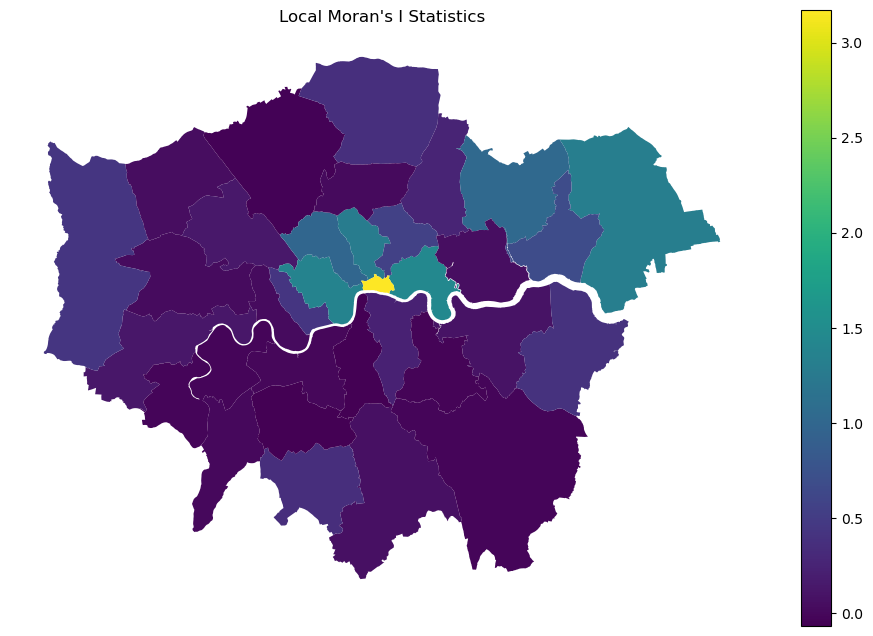

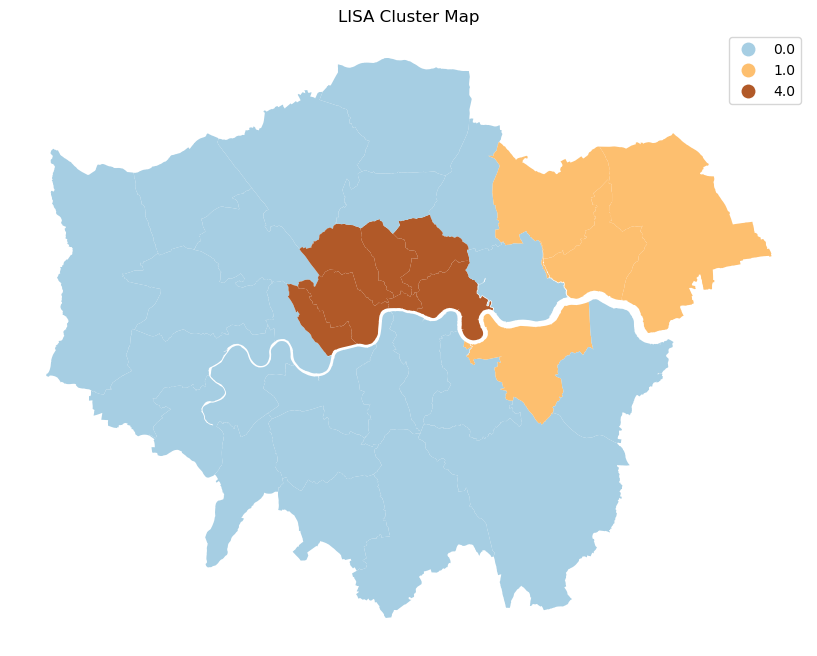

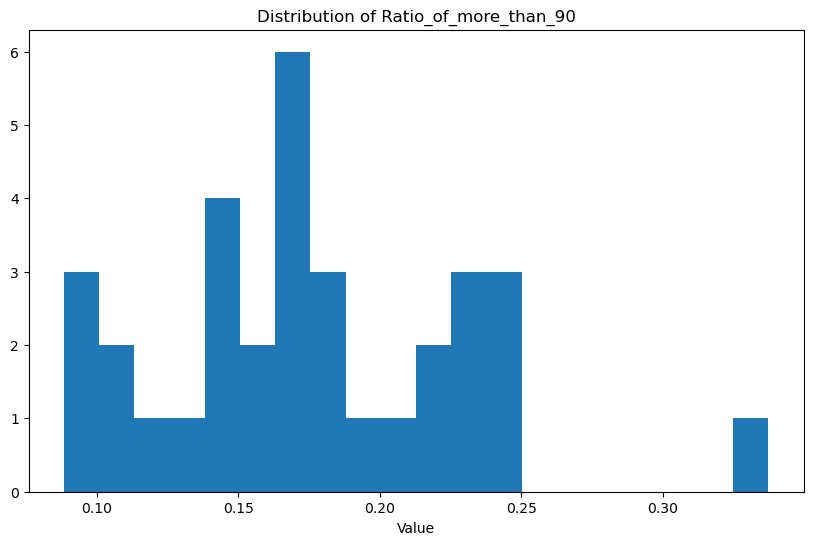

count    33.000000
mean      0.176067
std       0.054405
min       0.088400
25%       0.140200
50%       0.169800
75%       0.213800
max       0.337300
Name: Ratio_of_more_than_90, dtype: float64
count    33.000000
mean      0.444497
std       0.677907
min      -0.066242
25%       0.017070
50%       0.142216
75%       0.559219
max       3.172065
dtype: float64
Number of significant clusters: 11


In [37]:
# Plot Local Moran's I
fig, ax = plt.subplots(figsize=(12, 8))
borough_ratio.plot(column='Ii', legend=True, ax=ax)
plt.title("Local Moran's I Statistics")
plt.axis('off')
plt.show()

# LISA Cluster Map
sig = 0.1
labels = ['Not Significant', 'Low-Low', 'Low-High', 'High-Low', 'High-High']
colors = ['white', 'blue', 'lightblue', 'pink', 'red']

# Standardize the variable of interest
y_std = (y - y.mean()) / y.std()
lag_std = weights.sparse.dot(y_std)

# Create significance masks
sig_mask = local_moran.p_sim < sig

# Create cluster categories
borough_ratio['quadrant'] = np.zeros(len(y))
borough_ratio.loc[sig_mask, 'quadrant'] = np.where(y_std < 0,
    np.where(lag_std < 0, 1, 2),
    np.where(lag_std < 0, 3, 4))[sig_mask]

# Plot LISA clusters
fig, ax = plt.subplots(figsize=(12, 8))
borough_ratio.plot(column='quadrant', categorical=True, k=5, cmap='Paired',
                  legend=True, ax=ax)
plt.title('LISA Cluster Map')
plt.axis('off')
plt.show()

# Additional analysis plots
plt.figure(figsize=(10, 6))
plt.hist(y, bins=20)
plt.title('Distribution of Ratio_of_more_than_90')
plt.xlabel('Value')
plt.show()

print(y.describe())
# print(local_moran.Is.describe())
print(pd.Series(local_moran.Is).describe())

print(f"Number of significant clusters: {(local_moran.p_sim < 0.1).sum()}")

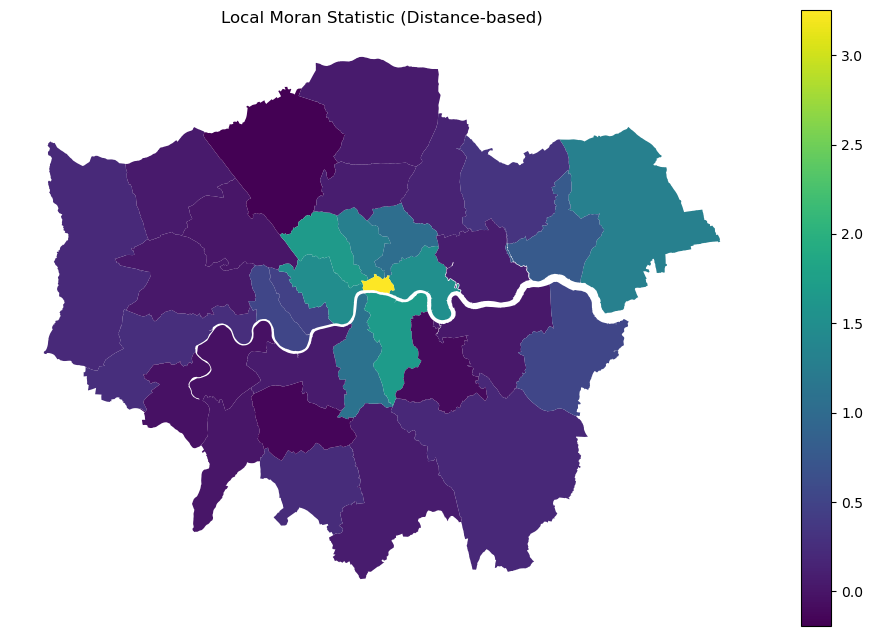

In [38]:
# Distance-based weights (20km)
centroids = borough_ratio.geometry.centroid
coords = np.column_stack((centroids.x, centroids.y))
knn = KNN.from_dataframe(borough_ratio, k=4)  # Approximate 20km neighbors
knn.transform = 'r'

# Calculate Local Moran's I with distance weights
local_moran_dist = Moran_Local(y, knn)

# Add results to GeoDataFrame
borough_ratio['Ii_dist'] = local_moran_dist.Is

# Plot results with distance-based weights
fig, ax = plt.subplots(figsize=(12, 8))
borough_ratio.plot(column='Ii_dist', legend=True, ax=ax)
plt.title("Local Moran Statistic (Distance-based)")
plt.axis('off')
plt.show()

In [39]:
from libpysal.weights import Queen, lag_spatial
from esda.moran import Moran_BV, Moran_Local_BV

# load data
connect = pd.read_csv("data/connect.csv")
borough = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

# merge the data
borough_connect = borough.merge(connect, left_on="GSS_CODE", right_on="Borough_code")

Bivariate Moran's I between Monthly_rent_2023 and Ratio_of_more_than_90: 0.397
p-value: 0.001


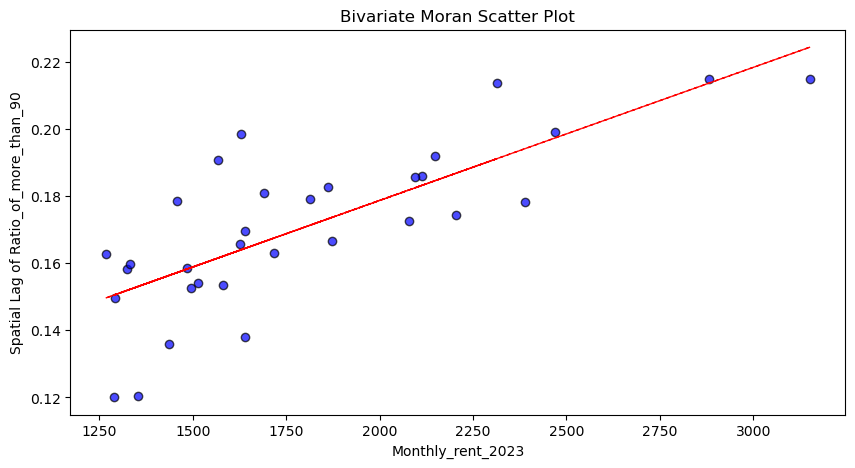

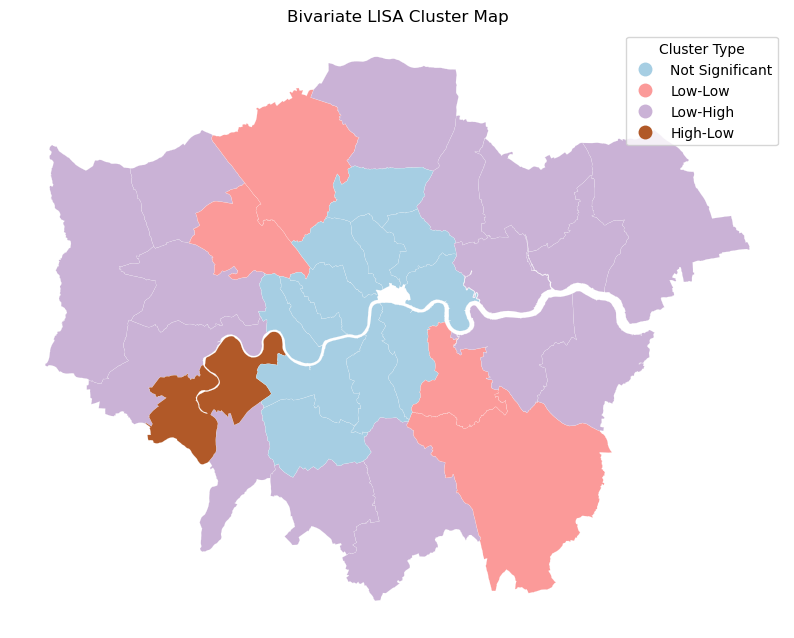

In [40]:
# analyse the spatial autocorrelation of monthly rent and airbnbs breaking the rule
# Variables
var1 = 'Monthly_rent_2023'
var2 = 'Ratio_of_more_than_90'

# Check for and handle missing data
borough_connect.dropna(subset=[var1, var2], inplace=True)

# Create weights and row-standardize them
weights = Queen.from_dataframe(borough_connect, use_index=True)
weights.transform = 'r'

# Bivariate Moran's I
moran_bv = Moran_BV(borough_connect[var1], borough_connect[var2], weights)
print(f"Bivariate Moran's I between {var1} and {var2}: {moran_bv.I:.3f}")
print(f"p-value: {moran_bv.p_sim:.3f}")

# Bivariate Moran Plot
fig, ax = plt.subplots(figsize=(10, 5))
spatial_lag_var2 = lag_spatial(weights, borough_connect[var2])  # Calculate the spatial lag of var2
scatter = ax.scatter(borough_connect[var1], spatial_lag_var2, color='blue', edgecolor='k', alpha=0.7)
fit = np.polyfit(borough_connect[var1], spatial_lag_var2, 1)
ax.plot(borough_connect[var1], np.polyval(fit, borough_connect[var1]), color='red', linestyle='--', linewidth=1)
ax.set_title('Bivariate Moran Scatter Plot')
ax.set_xlabel(var1)
ax.set_ylabel(f"Spatial Lag of {var2}")
plt.show()

# Bivariate Local Moran's I
local_moran_bv = Moran_Local_BV(borough_connect[var1], borough_connect[var2], weights)

# LISA Plot (Bivariate)
fig, ax = plt.subplots(figsize=(10, 10))
borough_connect.assign(cl=local_moran_bv.q).plot(column='cl', categorical=True, 
                                                 cmap='Paired', linewidth=0.1, ax=ax, 
                                                 edgecolor='white', legend=True)
labels = ['Not Significant', 'Low-Low', 'Low-High', 'High-Low', 'High-High']
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1, 1))
    legend.set_title('Cluster Type')
    for text, label in zip(legend.get_texts(), labels):
        text.set_text(label)

ax.set_title('Bivariate LISA Cluster Map')
ax.set_axis_off()
plt.show()

Bivariate Moran's I between Vacant_Ratio and Ratio_of_more_than_90: 0.035
p-value: 0.336


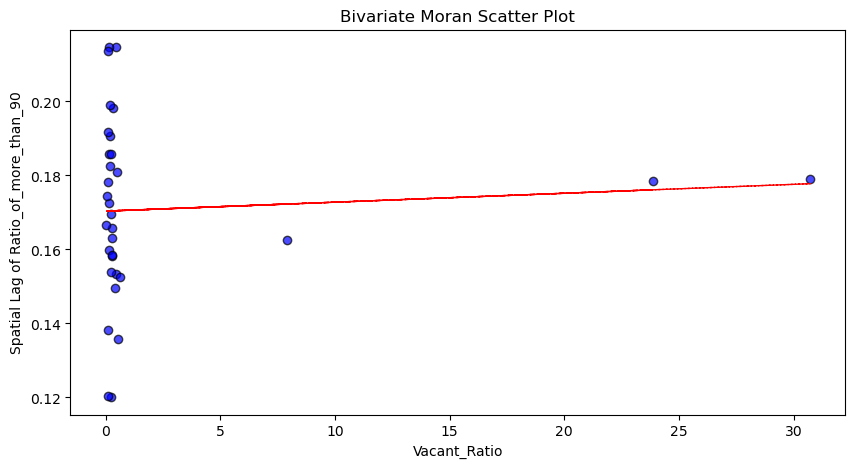

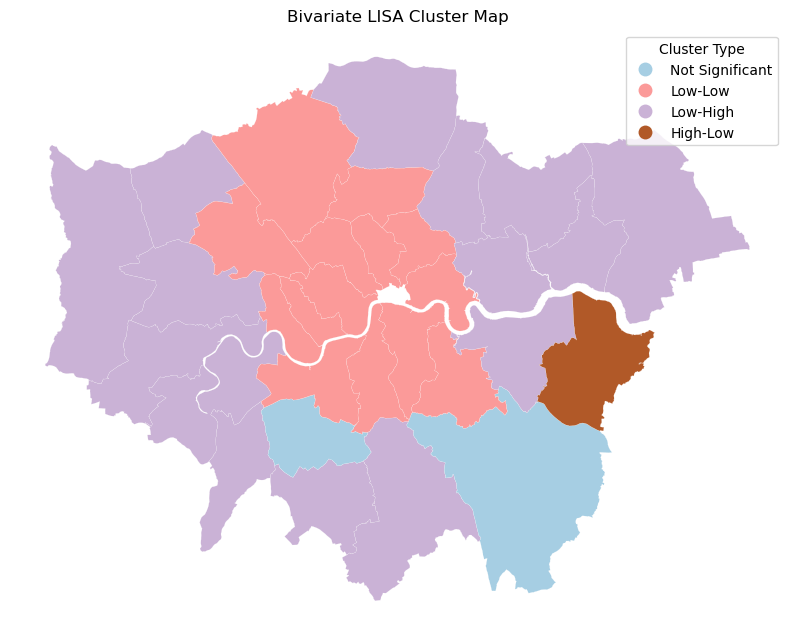

In [41]:
# analyse the spatial autocorrelation of vacant ratio and airbnbs breaking the rule
# Variables
var1 = 'Vacant_Ratio'
var2 = 'Ratio_of_more_than_90'

# Check for and handle missing data
borough_connect.dropna(subset=[var1, var2], inplace=True)

# Create weights and row-standardize them
weights = Queen.from_dataframe(borough_connect, use_index=True)
weights.transform = 'r'

# Bivariate Moran's I
moran_bv = Moran_BV(borough_connect[var1], borough_connect[var2], weights)
print(f"Bivariate Moran's I between {var1} and {var2}: {moran_bv.I:.3f}")
print(f"p-value: {moran_bv.p_sim:.3f}")

# Bivariate Moran Plot
fig, ax = plt.subplots(figsize=(10, 5))
spatial_lag_var2 = lag_spatial(weights, borough_connect[var2])  # Calculate the spatial lag of var2
scatter = ax.scatter(borough_connect[var1], spatial_lag_var2, color='blue', edgecolor='k', alpha=0.7)
fit = np.polyfit(borough_connect[var1], spatial_lag_var2, 1)
ax.plot(borough_connect[var1], np.polyval(fit, borough_connect[var1]), color='red', linestyle='--', linewidth=1)
ax.set_title('Bivariate Moran Scatter Plot')
ax.set_xlabel(var1)
ax.set_ylabel(f"Spatial Lag of {var2}")
plt.show()

# Bivariate Local Moran's I
local_moran_bv = Moran_Local_BV(borough_connect[var1], borough_connect[var2], weights)

# LISA Plot (Bivariate)
fig, ax = plt.subplots(figsize=(10, 10))
borough_connect.assign(cl=local_moran_bv.q).plot(column='cl', categorical=True, 
                                                 cmap='Paired', linewidth=0.1, ax=ax, 
                                                 edgecolor='white', legend=True)
labels = ['Not Significant', 'Low-Low', 'Low-High', 'High-Low', 'High-High']
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1, 1))
    legend.set_title('Cluster Type')
    for text, label in zip(legend.get_texts(), labels):
        text.set_text(label)

ax.set_title('Bivariate LISA Cluster Map')
ax.set_axis_off()
plt.show()

In [148]:
# SAR model
from spreg import ML_Lag

Missing values:
 Monthly_rent_2023        1
Vacant_Ratio             0
Ratio_of_more_than_90    0
dtype: int64
=== SAR Model Results ===
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :           w
Dependent Variable  :Ratio_of_more_than_90                Number of Observations:          32
Mean dependent var  :      0.1710                Number of Variables   :           4
S.D. dependent var  :      0.0468                Degrees of Freedom    :          28
Pseudo R-squared    :      0.6509
Spatial Pseudo R-squared:  0.6014
Log likelihood      :     69.5087
Sigma-square ML     :      0.0007                Akaike info criterion :    -131.017
S.E of regression   :      0.0272                Schwarz criterion     :    -125.155

------------------------------------------------------------------------------------
  

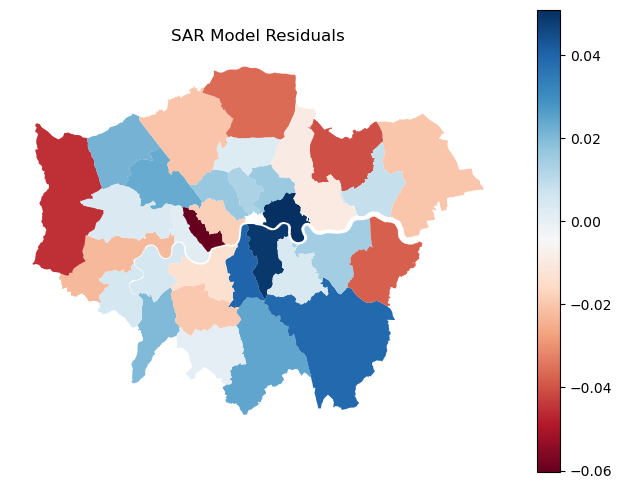

In [149]:
# Import data
data = pd.read_csv("data/connect.csv")
shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

# Merge data and transform coordinate system
zone = shp.merge(data, left_on="GSS_CODE", right_on="Borough_code")
zone = zone.to_crs("EPSG:27700")

# Check and remove missing values
columns = ['Monthly_rent_2023', 'Vacant_Ratio', 'Ratio_of_more_than_90']
print("Missing values:\n", zone[columns].isna().sum())
zone = zone.dropna(subset=columns)

# Construct spatial weights matrix
w = Queen.from_dataframe(zone)
w.transform = 'r'

# Prepare variables
y = zone['Ratio_of_more_than_90'].values.reshape(-1, 1)
X = zone[['Monthly_rent_2023', 'Vacant_Ratio']].values

# Fit Spatial Lag Model
sar_model = ML_Lag(y, X, w=w,
                   name_y='Ratio_of_more_than_90',
                   name_x=['Monthly_rent_2023', 'Vacant_Ratio'],
                   name_w='w')

# Output model results
print("=== SAR Model Results ===")
print(sar_model.summary)

# Visualize residuals
zone['residuals'] = sar_model.u
fig, ax = plt.subplots(figsize=(8, 6))
zone.plot(column='residuals', cmap='RdBu', legend=True, ax=ax)
plt.title("SAR Model Residuals")
plt.axis('off')
plt.show()

In [150]:
print(zone.geometry.type.unique())

['Polygon' 'MultiPolygon']


In [151]:
# GWR model
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

Missing Values Situation:
 Monthly_rent_2023        0
Vacant_Ratio             0
Ratio_of_more_than_90    0
dtype: int64


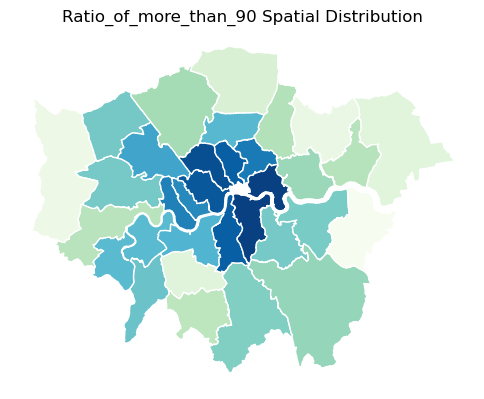

In [152]:
# Calculate geometric centroids and extract coordinates
zone['centro'] = zone.geometry.centroid
zone['X'] = zone['centro'].x
zone['Y'] = zone['centro'].y

# Check for and handle missing values
print("Missing Values Situation:\n", zone[['Monthly_rent_2023', 'Vacant_Ratio', 'Ratio_of_more_than_90']].isna().sum())
zone = zone.dropna(subset=['Monthly_rent_2023', 'Vacant_Ratio', 'Ratio_of_more_than_90'])

# Visualize the distribution of the dependent variable
fig, ax = plt.subplots(figsize=(6, 6))
zone.plot(column="Ratio_of_more_than_90", cmap='GnBu', edgecolor='white', ax=ax)
ax.set_axis_off()
plt.title("Ratio_of_more_than_90 Spatial Distribution")
plt.show()

Optimal Bandwidth Size: 23.0
Model type                                                         Gaussian
Number of observations:                                                  32
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.026
Log-likelihood:                                                      68.671
AIC:                                                               -131.341
AICc:                                                              -127.860
BIC:                                                               -100.481
R2:                                                                   0.623
Adj. R2:                                                              0.597

Variable                              Est.         SE  t(Est/SE)    p-value
-------------------------------

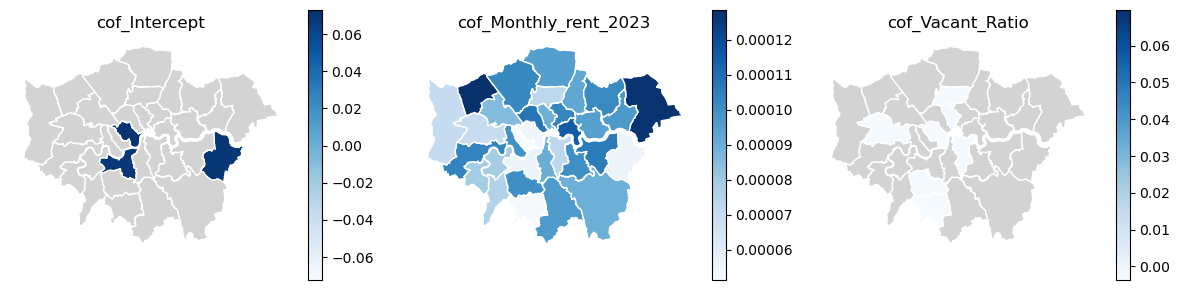

In [153]:
# Prepare data needed for GWR
g_y = zone['Ratio_of_more_than_90'].values.reshape((-1, 1))
g_X = zone[['Monthly_rent_2023', 'Vacant_Ratio']].values
g_coords = list(zip(zone['X'], zone['Y']))

# Bandwidth selection (GWR)
gwr_selector = Sel_BW(g_coords, g_y, g_X, fixed=False)
gwr_bw = gwr_selector.search(search_method='golden_section', criterion='AICc', bw_min=2, bw_max=32)
print('Optimal Bandwidth Size:', gwr_bw)

# Fit GWR model
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw, fixed=False, kernel='bisquare', constant=True, spherical=True).fit()
print(gwr_results.summary())

# Extract regression parameters and significance
var_names = ['cof_Intercept', 'cof_Monthly_rent_2023', 'cof_Vacant_Ratio']
gwr_coefs = pd.DataFrame(gwr_results.params, columns=var_names)
gwr_tvals = pd.DataFrame(gwr_results.filter_tvals())

# Combine regression results with spatial data
georgia_data_geo = gpd.GeoDataFrame(zone, geometry=gpd.points_from_xy(zone.X, zone.Y))
georgia_data_geo = georgia_data_geo.join(gwr_coefs)
georgia_shp_geo = gpd.sjoin(zone, georgia_data_geo, how="inner", predicate='intersects').reset_index(drop=True)

# Visualize regression coefficients and areas of significance
fig, axes = plt.subplots(1, len(var_names), figsize=(12, 3))
for i, ax in enumerate(axes):
    var = var_names[i]
    georgia_shp_geo.plot(column=var, edgecolor='white', cmap='Blues', legend=True, ax=ax)
    ax.set_title(var)
    ax.set_axis_off()

    # Determine significance
    threshold = 1.96
    significant = (gwr_tvals.iloc[:, i].abs() > threshold)
    georgia_shp_geo[~significant].plot(color='lightgrey', ax=ax, edgecolor='white')

plt.tight_layout()
plt.show()

In [154]:
print(zone.geometry.type.unique())

['Polygon' 'MultiPolygon']


In [155]:
# Assuming your data is already loaded into 'zone'
g_y_rent = zone['Monthly_rent_2023'].values.reshape((-1, 1))
g_X_rent = zone[['Ratio_of_more_than_90']].values
g_coords = list(zip(zone['X'], zone['Y']))

# Automatically set bw_min and bw_max based on the number of observations
n_obs = len(g_coords)  # Number of observations
bw_min = 2  # Minimum bandwidth, should be a positive integer
bw_max = max(bw_min, n_obs - 1)  # Ensures bw_max does not exceed n_obs - 1

# Initialize bandwidth selector with dynamic bandwidth settings
gwr_selector_rent = Sel_BW(g_coords, g_y_rent, g_X_rent, fixed=False)

# Search for optimal bandwidth using the golden section search method
gwr_bw_rent = gwr_selector_rent.search(search_method='golden_section', criterion='AICc', bw_min=bw_min, bw_max=bw_max)
print('Optimal Bandwidth Size for Rent:', gwr_bw_rent)

# Fit GWR model with the determined optimal bandwidth
gwr_results_rent = GWR(g_coords, g_y_rent, g_X_rent, gwr_bw_rent, fixed=False, kernel='bisquare').fit()
print(gwr_results_rent.summary())

Optimal Bandwidth Size for Rent: 27.0
Model type                                                         Gaussian
Number of observations:                                                  32
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                        2861190.859
Log-likelihood:                                                    -227.822
AIC:                                                                459.644
AICc:                                                               462.502
BIC:                                                            2861086.887
R2:                                                                   0.580
Adj. R2:                                                              0.566

Variable                              Est.         SE  t(Est/SE)    p-value
----------------------

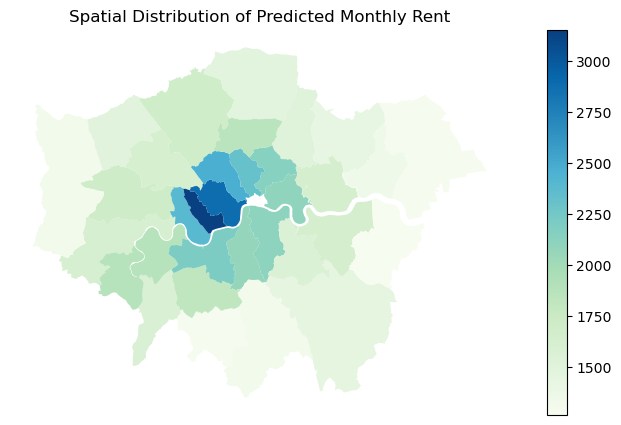

In [156]:
fig, ax = plt.subplots(figsize=(10, 5))
zone.plot(column='Monthly_rent_2023', cmap='GnBu', legend=True, ax=ax)
ax.set_title("Spatial Distribution of Predicted Monthly Rent")
ax.set_axis_off()
plt.show()

In [157]:
# Assuming your data is already loaded into 'zone'
g_coords = list(zip(zone['X'], zone['Y']))

# Define independent and dependent variables for the Vacant_Ratio model
g_y_vacant = zone['Vacant_Ratio'].values.reshape((-1, 1))
g_X_vacant = zone[['Ratio_of_more_than_90']].values

# Automatically set bw_min and bw_max based on the number of observations
n_obs = len(g_coords)  # Number of observations
bw_min = 2  # Minimum bandwidth, should be a positive integer
bw_max = max(bw_min, n_obs - 1)  # Ensures bw_max does not exceed n_obs - 1

# Initialize bandwidth selector with dynamic bandwidth settings for Vacant_Ratio
gwr_selector_vacant = Sel_BW(g_coords, g_y_vacant, g_X_vacant, fixed=False)

# Search for optimal bandwidth using the golden section search method for Vacant_Ratio
gwr_bw_vacant = gwr_selector_vacant.search(search_method='golden_section', criterion='AICc', bw_min=bw_min, bw_max=bw_max)
print('Optimal Bandwidth Size for Vacant Ratio:', gwr_bw_vacant)

# Fit GWR model with the determined optimal bandwidth for Vacant_Ratio
gwr_results_vacant = GWR(g_coords, g_y_vacant, g_X_vacant, gwr_bw_vacant, fixed=False, kernel='bisquare').fit()
print(gwr_results_vacant.summary())

Optimal Bandwidth Size for Vacant Ratio: 28.0
Model type                                                         Gaussian
Number of observations:                                                  32
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1298.658
Log-likelihood:                                                    -104.660
AIC:                                                                213.319
AICc:                                                               216.176
BIC:                                                               1194.686
R2:                                                                   0.090
Adj. R2:                                                              0.060

Variable                              Est.         SE  t(Est/SE)    p-value
--------------

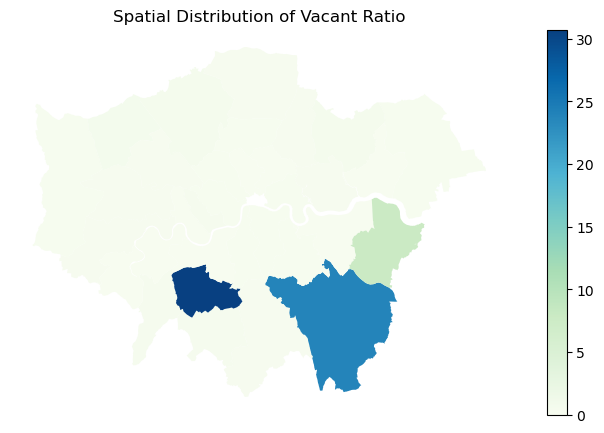

In [158]:
fig, ax = plt.subplots(figsize=(10, 5))
# Assuming 'zone' contains polygon geometries
zone.plot(column='Vacant_Ratio', cmap='GnBu', legend=True, ax=ax)
ax.set_title("Spatial Distribution of Vacant Ratio")
ax.set_axis_off()
plt.show()

In [159]:
print(zone.geometry.type.unique())

['Polygon' 'MultiPolygon']


In [160]:
# Assuming 'gwr_results_rent' is the output from your GWR model
zone['coefficient'] = gwr_results_rent.params[:, 1]  # Add coefficients
zone['t_values'] = gwr_results_rent.tvalues[:, 1]  # Add t-values

In [161]:
print(zone.geometry.type.unique())

['Polygon' 'MultiPolygon']


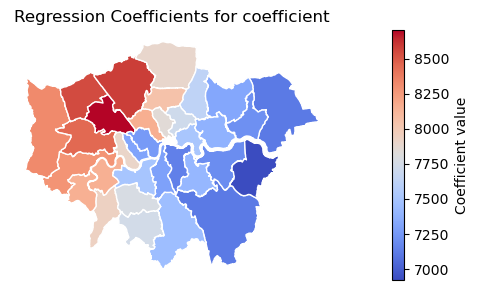

In [162]:
# Define the variable names to be visualized, corresponding to the regression results added
var_names = ['coefficient']  # Adjust this if more variables from the model should be visualized

fig, axes = plt.subplots(1, len(var_names), figsize=(12, 3))

# Ensure `axes` is iterable
if len(var_names) == 1:
    axes = [axes]

for i, var in enumerate(var_names):
    ax = axes[i]  # Access each subplot axis
    zone.plot(column=var, cmap='coolwarm', legend=True, ax=ax, edgecolor='white', legend_kwds={'label': "Coefficient value"})
    ax.set_title(f'Regression Coefficients for {var}')
    ax.set_axis_off()

    # Highlight non-significant areas based on a significance threshold
    threshold = 1.96
    non_significant = zone['t_values'].abs() < threshold  # Ensuring the use of absolute value for significance checking
    zone.loc[non_significant].plot(ax=ax, color='lightgrey', edgecolor='white')

plt.tight_layout()
plt.show()

In [163]:
# Fit GWR for Monthly_rent_2023
gwr_model_rent = GWR(g_coords, zone['Monthly_rent_2023'].values.reshape((-1, 1)),
                     zone[['Ratio_of_more_than_90']].values.reshape((-1, 1)), gwr_bw_rent).fit()

# Fit GWR for Vacant_Ratio
gwr_model_vacant = GWR(g_coords, zone['Vacant_Ratio'].values.reshape((-1, 1)),
                       zone[['Ratio_of_more_than_90']].values.reshape((-1, 1)), gwr_bw_vacant).fit()

# Extract coefficients and t-values for each model
rent_coefs = pd.DataFrame(gwr_model_rent.params, columns=['Intercept', 'Effect_of_Ratio_of_more_than_90_on_Rent'])
rent_tvals = pd.DataFrame(gwr_model_rent.tvalues, columns=['t_Intercept', 't_Effect_on_Rent'])

vacant_coefs = pd.DataFrame(gwr_model_vacant.params, columns=['Intercept', 'Effect_of_Ratio_of_more_than_90_on_Vacancy'])
vacant_tvals = pd.DataFrame(gwr_model_vacant.tvalues, columns=['t_Intercept', 't_Effect_on_Vacancy'])

In [164]:
# Add results directly to zone GeoDataFrame
zone['Rent_Effect'] = rent_coefs['Effect_of_Ratio_of_more_than_90_on_Rent']
zone['Vacancy_Effect'] = vacant_coefs['Effect_of_Ratio_of_more_than_90_on_Vacancy']

# Check significance and add to zone
zone['Significant_Rent'] = rent_tvals['t_Effect_on_Rent'].abs() > 1.96
zone['Significant_Vacancy'] = vacant_tvals['t_Effect_on_Vacancy'].abs() > 1.96

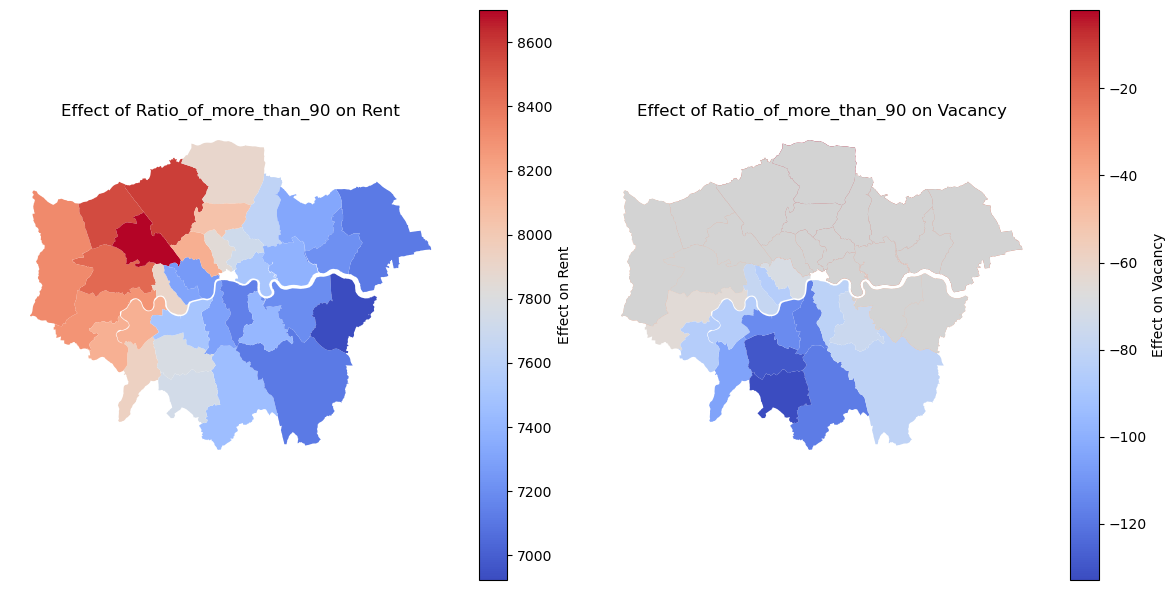

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Rent
zone.plot(column='Rent_Effect', cmap='coolwarm', ax=ax[0], legend=True,
          legend_kwds={'label': "Effect on Rent"})
zone[~zone['Significant_Rent']].plot(color='lightgrey', ax=ax[0])
ax[0].set_title('Effect of Ratio_of_more_than_90 on Rent')
ax[0].set_axis_off()

# Plot for Vacancy
zone.plot(column='Vacancy_Effect', cmap='coolwarm', ax=ax[1], legend=True,
          legend_kwds={'label': "Effect on Vacancy"})
zone[~zone['Significant_Vacancy']].plot(color='lightgrey', ax=ax[1])
ax[1].set_title('Effect of Ratio_of_more_than_90 on Vacancy')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()